# 01 - Accessing and querying the Survey Class and HDF5 file

The survey HDF5 file is a master look up table for each observation made by VIRUS for HETDEX. It can be accessed directly through the HDF5 survey file, or through the Survey class API. The Survey class includes information for the three dither set HETDEX observation. Any quantity related to an individual dither is provided in an array of length three. Fundamental properties of a shot and quality assessment values for seeing (fwhm), astrometry and transparency (response_4540) are tabulated to allow for querying of desired shots. 

We first introduce the basic API to query the Survey Class by sky coordinates to get a list of shots where fibers are located within that region. Later on in this notebook we show some basic querying of the Survey class and demonstrate a few examples.

### Initiate the Survey class :

In [1]:
%matplotlib inline
import tables as tb
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord

In [2]:
%run ../survey.py

In [4]:
survey = Survey('hdr1')

This calls the HDR1 survey class and sets each column in the survey table as an attribute to this object. This is how it looks through an astropy Table object:

In [5]:
Table(survey.hdfile.root.Survey[:])

field,date,obsid,objid,ra,dec,pa,fwhm,response_4540,darktime [3],datevobs,expnum [3],exptime [3],mjd [3],nstars_fit [3],shotid,timestamp [3],trajcdec,trajcpa,trajcra,xditherpos [3],xoffset [3],xrms [3],yditherpos [3],yoffset [3],yrms [3]
str12,int32,int32,str18,float32,float32,float32,float32,float32,float32,str12,int32,float32,float32,int32,int64,str18,float32,float32,float32,float32,float32,float32,float32,float32,float32
cosmos,20170103,2,COS10_W_000_W,149.888,1.88533,212.3,nan,0.0596,395.035 .. 395.088,20170103v002,1 .. 3,365.299 .. 364.999,57756.5 .. 57756.5,7 .. 7,20170103002,20170103T110904.9 .. 20170103T112218.8,1.88605,212.198,9.9924,0.0 .. 0.0,-2e-05 .. 0.0,0.22079 .. 0.24027,0.0 .. 0.0,-1e-05 .. -0.0,0.33429 .. 0.17898
cosmos,20170103,3,COS64_W,150.486,2.48316,213.83,2.002,nan,394.86 .. 395.298,20170103v003,1 .. 3,364.899 .. 365.149,57756.5 .. 57756.5,4 .. 3,20170103003,20170103T113542.7 .. 20170103T114854.4,2.48372,213.731,10.0323,0.0 .. 0.0,0.0 .. 1e-05,0.06435 .. 0.10983,0.0 .. 0.0,-0.0 .. 0.0,0.35298 .. 0.29886
cosmos,20170105,8,COS57_E,149.771,2.59229,146.1,2.443,nan,392.886 .. 395.387,20170105v008,1 .. 3,362.65 .. 365.349,57758.3 .. 57758.3,4 .. 5,20170105008,20170105T080628.7 .. 20170105T081941.3,2.59176,146.0,9.9848,0.0 .. 0.0,0.0 .. -0.0,0.0939 .. 0.41456,0.0 .. 0.0,-0.0 .. -0.0,0.20898 .. 0.03161
cosmos,20170105,9,COS19_E_000_E,149.973,2.09132,147.37,2.75,nan,395.135 .. 394.243,20170105v009,1 .. 3,365.049 .. 362.649,57758.4 .. 57758.4,5 .. 4,20170105009,20170105T083805.3 .. 20170105T085118.6,2.09014,147.273,9.9981,0.0 .. 0.0,2e-05 .. -0.0,0.40278 .. 0.12945,0.0 .. 0.0,3e-05 .. 0.00019,0.37773 .. 0.3977
cosmos,20170105,10,COS1_W,149.788,1.78598,212.03,2.006,nan,395.589 .. 394.662,20170105v010,1 .. 3,365.15 .. 364.951,57758.5 .. 57758.5,6 .. 7,20170105010,20170105T110147.7 .. 20170105T111502.4,1.78644,211.934,9.9858,0.0 .. 0.0,-0.0 .. 0.0,0.47294 .. 0.65877,0.0 .. 0.0,-0.0 .. 0.0,0.39384 .. 0.50996
cosmos,20170105,11,COS14_W,150.288,1.88586,212.29,2.541,nan,395.085 .. 395.289,20170105v011,1 .. 3,365.201 .. 365.05,57758.5 .. 57758.5,5 .. 4,20170105011,20170105T113048.4 .. 20170105T114400.1,1.88605,212.195,10.0191,0.0 .. 0.0,0.0 .. 0.0,0.26126 .. 0.14013,0.0 .. 0.0,-0.0 .. -0.0,0.54034 .. 0.35707
cosmos,20170106,1,COS18_E,149.872,2.09077,147.38,2.415,nan,395.435 .. 395.234,20170106v001,1 .. 3,365.35 .. 365.299,57759.3 .. 57759.3,4 .. 5,20170106001,20170106T080409.9 .. 20170106T081721.6,2.09014,147.275,9.9914,0.0 .. 0.0,-0.0 .. -1e-05,0.63825 .. 0.59467,0.0 .. 0.0,-1e-05 .. 1e-05,0.27743 .. 0.40041
cosmos,20170106,2,COS10_E,149.872,1.9904,147.64,2.411,nan,393.139 .. 394.588,20170106v002,1 .. 3,363.1 .. 364.95,57759.4 .. 57759.4,5 .. 5,20170106002,20170106T083407.8 .. 20170106T084720.0,1.98981,147.536,9.9914,0.0 .. 0.0,0.0 .. 0.0,0.11002 .. 0.56246,0.0 .. 0.0,0.0 .. -0.0,0.30044 .. 0.2474
cosmos,20170106,3,COS19_W,149.988,1.98563,212.56,2.764,nan,396.448 .. 394.987,20170106v003,1 .. 3,365.0 .. 365.25,57759.5 .. 57759.5,4 .. 4,20170106003,20170106T112617.4 .. 20170106T113932.3,1.98525,212.457,9.9992,0.0 .. 0.0,-0.0 .. -0.0,0.17696 .. 0.12486,0.0 .. 0.0,0.0 .. -0.0,0.30677 .. 0.4222


It also converts RA and DEC into astropy coordinate objects.

In [6]:
survey.coords

<SkyCoord (ICRS): (ra, dec) in deg
    [( 149.88757324,   1.88532996), ( 150.48582458,   2.48316002),
     ( 149.77142334,   2.59228992), ..., ( 207.99421692,  50.93356705),
     ( 214.09381104,  51.48942184), ( 222.49749756,  50.93349075)]>

Shots are labeled based on their observation date and observation ID:

In [7]:
survey.date

array([20170103, 20170103, 20170105, ..., 20190209, 20190209, 20190209], dtype=int32)

In [8]:
survey.obsid

array([ 2,  3,  8, ..., 25, 26, 27], dtype=int32)

A specific shot can be linked either by an integer combination of these two values, called `shotid`, or the `DATEvOBS` form:

In [9]:
survey.datevobs

array(['20170103v002', '20170103v003', '20170105v008', ..., '20190209v025',
       '20190209v026', '20190209v027'], 
      dtype='|S12')

In [10]:
survey.shotid

array([20170103002, 20170103003, 20170105008, ..., 20190209025,
       20190209026, 20190209027])

## Searching for shots near a sky coordinate

Most users searching for observations will want to get a list of observations/shots at a specific sky position. Each shot has a single associated sky coordinate. We can retrieve a list of shots that may contain fibers in a specific region. However, because of the varying and non-contiguous footprint of VIRUS, this is not an immediate guarantee a region has been observed. You must further query fibers in each shot to determine this. See notebook 04- Querying the Fiber Class. 

### get_shotlist()
This function which operates on the Survey class object. An astropy coordinates object is required as input.

In [11]:
coords = SkyCoord(11.628530 * u.deg, 0.081790 * u.deg, frame='icrs')

We can either search a rectangular region, width and height in degrees:

In [15]:
shotlist = survey.get_shotlist(coords, width=0.5, height=0.2)

In [15]:
shotlist

array([20171119003, 20181003009, 20181005017, 20181107014])

or we can search a circular aperture with a radius given in degress, or in an astropy quantity object:

In [14]:
shotlist = survey.get_shotlist(coords, radius=10*u.arcmin)

In [16]:
shotlist

array([20171119003, 20181003009, 20181005017, 20181107014])

From here a user can take their shotlist and query the position on the Fibers class and see if their region of interest is observed in the survey.

## Basic querying for the Survey Class

The Survey HDF5 itself contains information about the quality of each observation. A user can query different parameters and plot up general shot quantities. For example, we can compare the distribution of throughput values (technically the response at 4540 AA) between the HETDEX spring and HETDEX fall fields:

### Example: Plotting up the canonical throughput value at 4540 AA

In [17]:
idx_spring = np.where( (survey.field == 'dex-spring') * np.isfinite(survey.response_4540) )

In [18]:
idx_fall = np.where( (survey.field == 'dex-fall') * np.isfinite(survey.response_4540))

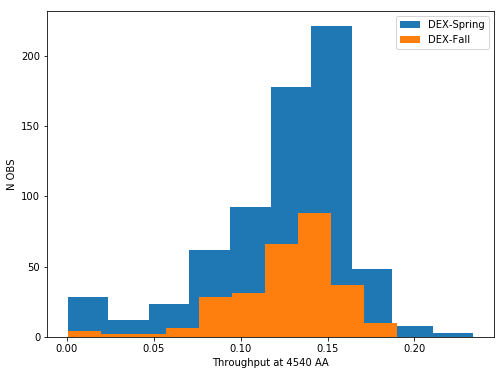

In [19]:
plt.figure(figsize=(8,6))
plt.hist(survey.response_4540[idx_spring], label = 'DEX-Spring')
plt.hist(survey.response_4540[idx_fall], label = 'DEX-Fall')
plt.xlabel('Throughput at 4540 AA')
plt.ylabel('N OBS')
plt.legend()

### Example: Plotting up the locations of all cosmos shots:

In [20]:
idx_cosmos = np.where(survey.field == 'cosmos')

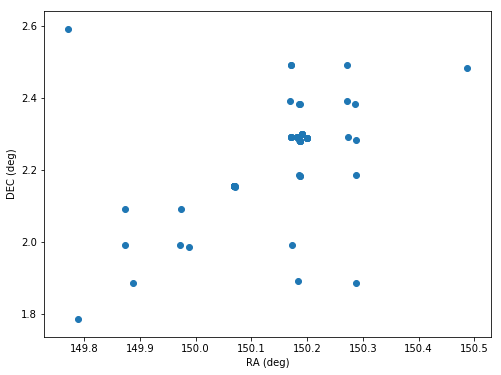

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(survey.ra[idx_cosmos],survey.dec[idx_cosmos])
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.show()

### Example: Plot up dither offset positions for all shots

The attributes xditherpos and yditherpos provide the dither offset values in arcseconds for each dither of each dither shot. They are each arrays of length three representing dithers 1,2,3 respectively.

In [22]:
np.shape(survey.xditherpos)

(1899, 3)

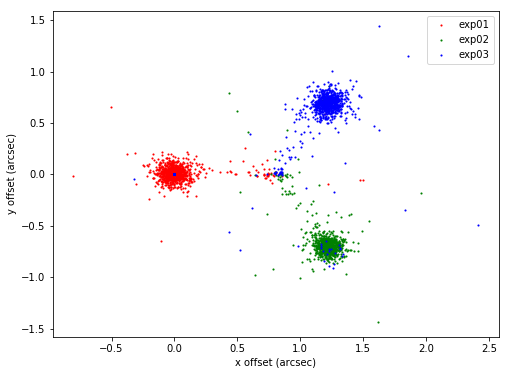

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(survey.xditherpos[:,0],survey.yditherpos[:,0], color='r', marker="o", s=1.2, label='exp01')
plt.scatter(survey.xditherpos[:,1],survey.yditherpos[:,1], color='g', marker="o", s=1.2, label='exp02')
plt.scatter(survey.xditherpos[:,2],survey.yditherpos[:,2], color='b', marker="o", s=1.2, label='exp03')
plt.xlabel('x offset (arcsec)')
plt.ylabel('y offset (arcsec)')
plt.legend()
plt.show()

## Exploring the Survey HDF5 File

The hdfile attribute contains the link to the survey HDF5 file. Calling it will show you all the information in the HDF5 file. You may interact with this directly rather than using the Survey class initiation. 


In [27]:
survey.hdfile

File(filename=/work/03946/hetdex/hdr1/survey/survey_test.h5, title='Survey test file ', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) 'Survey test file '
/Survey (Table(1899,)) 'Main Survey Info'
  description := {
  "field": StringCol(itemsize=12, shape=(), dflt='', pos=0),
  "date": Int32Col(shape=(), dflt=0, pos=1),
  "obsid": Int32Col(shape=(), dflt=0, pos=2),
  "objid": StringCol(itemsize=18, shape=(), dflt='', pos=3),
  "ra": Float32Col(shape=(), dflt=0.0, pos=4),
  "dec": Float32Col(shape=(), dflt=0.0, pos=5),
  "pa": Float32Col(shape=(), dflt=0.0, pos=6),
  "fwhm": Float32Col(shape=(), dflt=0.0, pos=7),
  "response_4540": Float32Col(shape=(), dflt=0.0, pos=8),
  "darktime": Float32Col(shape=(3,), dflt=0.0, pos=9),
  "datevobs": StringCol(itemsize=12, shape=(), dflt='', pos=10),
  "expnum": Int32Col(shape=(3,), dflt=0, pos=11),
  "exptime": Float32Col(shape=(3,), dflt=0.0, pos=